Détection d'anomalies dans des logs Linux avec IA
Ce projet vise à analyser un fichier de logs Linux contenant 2k lignes (depuis Kaggle [link](https://www.kaggle.com/datasets/ggsri123/linux-logs?resource=download) ) et à détecter des comportements anormaux à l’aide de Machine Learning non supervisé.




In [10]:
import pandas as pd
import re # for regular expressions
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest #non supervised ml model for anomaly detection
from sklearn.preprocessing import LabelEncoder


## Load logs

In [19]:

with open("/content/Linux_2k.log", "r") as file:
    raw_logs = file.readlines()

# show headings
raw_logs[:5]

['Jun 14 15:16:01 combo sshd(pam_unix)[19939]: authentication failure; logname= uid=0 euid=0 tty=NODEVssh ruser= rhost=218.188.2.4 \n',
 'Jun 14 15:16:02 combo sshd(pam_unix)[19937]: check pass; user unknown\n',
 'Jun 14 15:16:02 combo sshd(pam_unix)[19937]: authentication failure; logname= uid=0 euid=0 tty=NODEVssh ruser= rhost=218.188.2.4 \n',
 'Jun 15 02:04:59 combo sshd(pam_unix)[20882]: authentication failure; logname= uid=0 euid=0 tty=NODEVssh ruser= rhost=220-135-151-1.hinet-ip.hinet.net  user=root\n',
 'Jun 15 02:04:59 combo sshd(pam_unix)[20884]: authentication failure; logname= uid=0 euid=0 tty=NODEVssh ruser= rhost=220-135-151-1.hinet-ip.hinet.net  user=root\n']

##  Parsing
Selon les colonnes Mois, Jour, Heure, Processus component, PID, Message

In [20]:
parsed_data = []
for line in raw_logs:
    match = re.match(r'(\w{3})\s+(\d{1,2})\s+(\d{2}:\d{2}:\d{2})\s+(\S+)\s+(\S+)\[(\d+)\]:\s+(.*)', line)
    if match:
        month, day, time, host, component, pid, message = match.groups()
        parsed_data.append([month, day, time, component, pid, message])

df = pd.DataFrame(parsed_data, columns=["Month", "Day", "Time", "Component", "PID", "Message"])
df.head()

,Month,Day,Time,Component,PID,Message
0,Jun,14,15:16:01,sshd(pam_unix),19939,authentication failure; logname= uid=0 euid=0 ...
1,Jun,14,15:16:02,sshd(pam_unix),19937,check pass; user unknown
2,Jun,14,15:16:02,sshd(pam_unix),19937,authentication failure; logname= uid=0 euid=0 ...
3,Jun,15,02:04:59,sshd(pam_unix),20882,authentication failure; logname= uid=0 euid=0 ...
4,Jun,15,02:04:59,sshd(pam_unix),20884,authentication failure; logname= uid=0 euid=0 ...


## Feature engineering

In [21]:
#add features to my dataframe
df['msg_len'] = df['Message'].apply(len) #generally longer or shorter messages are anomalies
df['has_failed'] = df['Message'].str.contains("fail|error|denied", case=False).astype(int) #some keywords of anomalies , 1 means  anomaly
df['has_root'] = df['Message'].str.contains("root", case=False).astype(int) # root is critical
df['hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce').dt.hour.fillna(0).astype(int) #to check suspect hours, such as night time

#encoding
le = LabelEncoder()
df['component_encoded'] = le.fit_transform(df['Component']) #encode text component/process
df.head()
df[:10]

,Month,Day,Time,Component,PID,Message,msg_len,has_failed,has_root,hour,component_encoded
0,Jun,14,15:16:01,sshd(pam_unix),19939,authentication failure; logname= uid=0 euid=0 ...,84,1,0,15,11
1,Jun,14,15:16:02,sshd(pam_unix),19937,check pass; user unknown,24,0,0,15,11
2,Jun,14,15:16:02,sshd(pam_unix),19937,authentication failure; logname= uid=0 euid=0 ...,84,1,0,15,11
3,Jun,15,02:04:59,sshd(pam_unix),20882,authentication failure; logname= uid=0 euid=0 ...,115,1,1,2,11
4,Jun,15,02:04:59,sshd(pam_unix),20884,authentication failure; logname= uid=0 euid=0 ...,115,1,1,2,11
5,Jun,15,02:04:59,sshd(pam_unix),20883,authentication failure; logname= uid=0 euid=0 ...,115,1,1,2,11
6,Jun,15,02:04:59,sshd(pam_unix),20885,authentication failure; logname= uid=0 euid=0 ...,115,1,1,2,11
7,Jun,15,02:04:59,sshd(pam_unix),20886,authentication failure; logname= uid=0 euid=0 ...,115,1,1,2,11
8,Jun,15,02:04:59,sshd(pam_unix),20892,authentication failure; logname= uid=0 euid=0 ...,115,1,1,2,11
9,Jun,15,02:04:59,sshd(pam_unix),20893,authentication failure; logname= uid=0 euid=0 ...,115,1,1,2,11


## ML : Isolation Forest model

In [22]:
features = df[["msg_len", "has_failed", "has_root", "hour", "component_encoded"]]
model = IsolationForest(contamination=0.02, random_state=42) #contamination of 2% of logs
df["anomaly"] = model.fit_predict(features)
df["anomaly"] = df["anomaly"].map({1: 0, -1: 1})
df["anomaly"].value_counts()

,count
anomaly,
0,1812
1,36


## Results visualisation

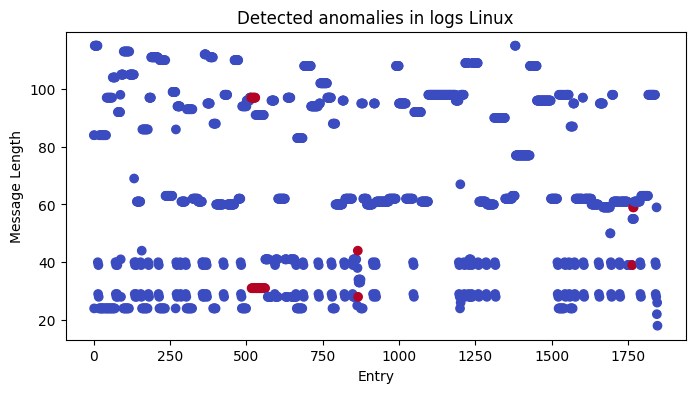

In [25]:
plt.figure(figsize=(8, 4))
plt.scatter(df.index, df['msg_len'], c=df['anomaly'], cmap='coolwarm')
plt.title("Detected anomalies in logs Linux")
plt.xlabel("Entry")
plt.ylabel("Message Length")
plt.show()

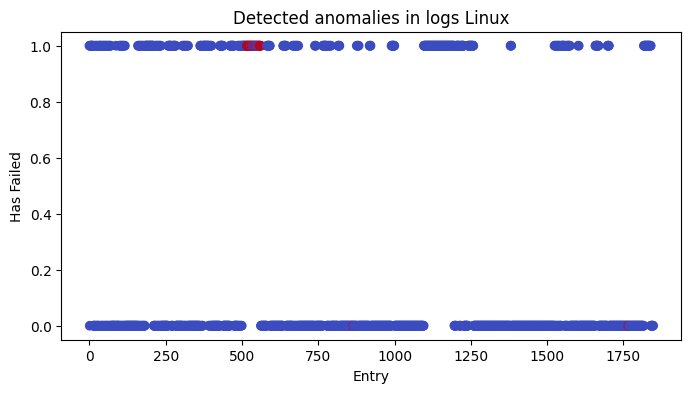

In [26]:
plt.figure(figsize=(8, 4))
plt.scatter(df.index, df['has_failed'], c=df['anomaly'], cmap='coolwarm')
plt.title("Detected anomalies in logs Linux")
plt.xlabel("Entry")
plt.ylabel("Has Failed")
plt.show()

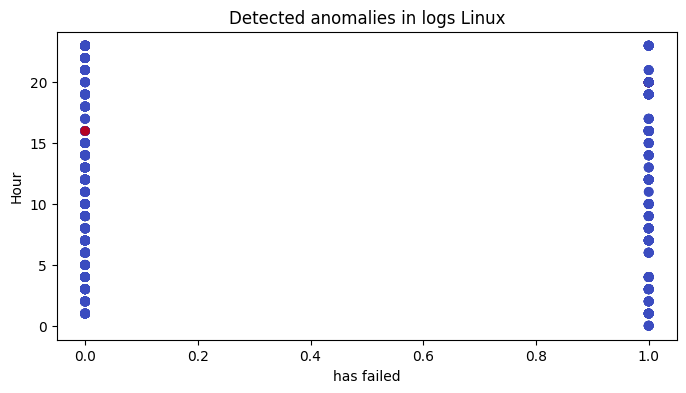

In [30]:
plt.figure(figsize=(8, 4))
plt.scatter(df['has_failed'], df['hour'], c=df['anomaly'], cmap='coolwarm')
plt.title("Detected anomalies in logs Linux")
plt.xlabel("has failed")
plt.ylabel("Hour")
plt.show()